# Neural Networks on Processed Images

## Author: Alexander Goudemond, Student Number: 219030365

This notebook will follow a similar structure to 013, however we will be refining and optimising the models for a patch size of 256 - trying to improve upon the benchmark both in terms of Mean IoU score, as well as appearance.

Our best models will then be used to generate videos - to show the predictions on other data - including test data!

Please ensure the following folders containg images exist:

drive > MyDrive > COMP700_Images > COMP700_Processed_Training_GT

drive > MyDrive > COMP700_Images > COMP700_Processed_Training_ST

drive > MyDrive > COMP700_Images > COMP700_Raw_Training_GT

drive > MyDrive > COMP700_Images > COMP700_Raw_Training_ST

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_128_GT

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_256_GT

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_512_GT

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_128_ST

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_256_ST

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_512_ST

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_Processed_Images_GT

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_Processed_Images_ST

------------------------------------------------------

Then, please ensure a seperate folder with the notebooks and text files exists:

drive > MyDrive > COMP700_Neural_Network_Code

------------------------------------------------------

The first 4 image folders were generated offline by the other notebooks and then uploaded to Google Drive, whereas the next 6 were generated by the notebook 011. The final 2 were generated by 015

# Installs

In [5]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [6]:
from os import getcwd, walk, mkdir, stat, remove
from os import sep # used later on, in a function, to print directory contents
from os.path import exists, basename, join

from shutil import copyfile

from PIL.Image import fromarray
import cv2

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, Input, Lambda
from keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from IPython.display import clear_output


In [7]:
print(tf.version.VERSION)

2.9.2


# Mount Drive

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
google_drive_path = "/drive/MyDrive"
training_data_directory = getcwd() + google_drive_path + "/COMP700_Images/"

# Functions to load images into variables

In [10]:
def readImagesViaMatplotlib(array):
    answer = []
    length = len(array)
    for i in range(length):
        answer.append( plt.imread(array[i]))

        if (i % 100 == 0):
            print("Processed", i, "images out of", length)
    
    print("Complete")
    return np.array(answer)
###

In [11]:
def getImagePaths(path):
    temp = []
    collection = []

    for root, dirs, files in walk(path):
      # print(root)

      if (len(files) != 0):
        for image in files:
          collection.append(root + "/" + image)
        
        temp.append(collection)
        collection = []
        
    return temp
###


In [12]:
from tensorflow import keras
from keras.utils import array_to_img

def display(display_list, title=[], figsize=(15, 15)):
    plt.figure(figsize=figsize)

    # update if title not provided
    if (len(title) == 0):
      title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i], wrap=True)
        
        # handle 2D and 3D images
        if (len(display_list[i].shape) == 3 ):
            plt.imshow( array_to_img(display_list[i]), cmap="gray")
        else:
            plt.imshow( display_list[i], cmap="gray")
            
        plt.axis('off')
    plt.tight_layout() # prevents overlap
    plt.show()
###


In [13]:
# global variables used for the model training to visualise results
# this will be updated before we train each model

sample_image = None
sample_mask = None

In [14]:
class DisplayCb(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions(self.model)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
  
class LearningRateReducerCb(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    old_lr = self.model.optimizer.lr.read_value()
    new_lr = old_lr * 0.99
    print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
    self.model.optimizer.lr.assign(new_lr)

In [15]:
def show_predictions(model, dataset=None):
    if dataset:
        for image, mask in dataset:
            pred_mask = model.predict(image[tf.newaxis, ...])
            display([image, mask, create_mask(pred_mask)])
    else:
        # sample_image, sample_mask are global variables
        display([sample_image, sample_mask,
                create_mask(model.predict(sample_image[tf.newaxis, ...]))])
###

def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]
###


The Mean IoU score is written here as well:

In [16]:
#IOU
def calculateMeanIouScore(model, x_test, y_test, pred_y):
    # pred_y = model.predict(x_test)
    # pred_y_thresholded = pred_y > 0.5

    intersection = np.logical_and(y_test, pred_y)
    union = np.logical_or(y_test, pred_y)

    iou_score = np.sum(intersection) / np.sum(union)

    # print("IoU score is: ", iou_score)

    return iou_score
###

In [17]:
def showTrainingMetrics(history, title):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 6))
    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    # plt.title(title)
    
    plt.plot(loss, 'b', label='Training loss')
    plt.plot(acc, 'r', label='Training accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Value")

    plt.legend()
    plt.grid()

    # only ptogress if val_accuracy part of history
    history_dict = history.history
    # print(history_dict.keys())
    if (len(history_dict.keys()) > 2):
        plt.subplot(1, 2, 2)

        plt.plot(val_loss, 'b', label='Validation loss')
        plt.plot(val_acc, 'r', label='Validation accuracy')
        plt.xlabel("Epochs")
        plt.ylabel("Value")

        plt.legend()
        plt.grid()

    plt.show()
###

In [18]:
def extractRhsString(string, symbol):
    index = string.rfind(symbol)
    return string[ index + len(symbol) : ]
###

In [19]:
# create directories for work we create
def tryMakeDirectories(current_directory, myList):
    path = ""
    for item in myList:
        # initialize
        if (path == ""):
            path = item
        else:
            path = path + "/" + item
            
        try:
            # join comes from os.path
            mkdir( join(current_directory, path) )
        except FileExistsError:
            # print("Folder already exists!")
            pass
        except:
            print("Unknown Error Encountered...")
###

# UNet Model Definition

In [20]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

'''
Original Author: Dr. Sreenivas Bhattiprolu
Source code: https://github.com/bnsreenu/python_for_microscopists/blob/master/204-207simple_unet_model.py
Github Repo: https://github.com/bnsreenu/python_for_microscopists
Accessed: 2022/10/28
'''
#########################################################################################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, INPUT_CHANNELS, OUTPUT_CHANNELS, name=""):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, INPUT_CHANNELS), name="Input")
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name="c1_a")(s)
    c1 = Dropout(0.1, name="c1_b")(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name="c1_c")(c1)
    p1 = MaxPooling2D((2, 2), name="p1")(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name="c2_a")(p1)
    c2 = Dropout(0.1, name="c2_b")(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name="c2_c")(c2)
    p2 = MaxPooling2D((2, 2), name="p2")(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name="c3_a")(p2)
    c3 = Dropout(0.2, name="c3_b")(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name="c3_c")(c3)
    p3 = MaxPooling2D((2, 2), name="p3")(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name="c4_a")(p3)
    c4 = Dropout(0.2, name="c4_b")(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name="c4_c")(c4)
    p4 = MaxPooling2D((2, 2), name="p4")(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name="c5_a")(p4)
    c5 = Dropout(0.3, name="c5_b")(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name="c5_c")(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name="u6_a")(c5)
    u6 = concatenate([u6, c4], name="u6_b")
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name="c6_a")(u6)
    c6 = Dropout(0.2, name="c6_b")(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name="c6_c")(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name="u7_a")(c6)
    u7 = concatenate([u7, c3], name="u7_b")
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name="c7_a")(u7)
    c7 = Dropout(0.2, name="c7_b")(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name="c7_c")(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', name="u8_a")(c7)
    u8 = concatenate([u8, c2], name="u8_b")
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name="c8_a")(u8)
    c8 = Dropout(0.1, name="c8_b")(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name="c8_c")(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same', name="u9_a")(c8)
    u9 = concatenate([u9, c1], axis=3, name="u9_b") # why axis=3 here?
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name="c9_a")(u9)
    c9 = Dropout(0.1, name="c9_b")(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name="c9_c")(c9)
     
    outputs = Conv2D(OUTPUT_CHANNELS, (1, 1), activation='sigmoid', name="Output")(c9) # modified
    # outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9) # original
    
    # modified
    # update name if provided
    if (len(name) > 0):
        model = Model(inputs=[inputs], outputs=[outputs], name=name)
    else:
        model = Model(inputs=[inputs], outputs=[outputs])

    # modified
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # model.summary()
    
    return model
#########################################################################################################################################

# Unet GT 256 Model

## Load images

Can take 20 minutes to load on a new runtime...

In [21]:
temp_path = getImagePaths(training_data_directory + "COMP700_Patchify_Images_Processed_Images_GT")
collection = []
labels = ["", "", "", ""]

for i in range(len(temp_path)):
    temp = temp_path[i][0]

    collection = temp_path[i]
    collection.sort()

    if ("Training/X" in temp):
      training_x = readImagesViaMatplotlib(collection)
      labels[0] = collection
    elif ("Training/Y" in temp):
      training_y = readImagesViaMatplotlib(collection)
      labels[1] = collection
    elif ("Test/X" in temp):
      test_x = readImagesViaMatplotlib(collection)
      labels[2] = collection
    elif ("Test/Y" in temp):
      test_y = readImagesViaMatplotlib(collection)
      labels[3] = collection
    else:
      print("Unknown path specified")

Processed 0 images out of 2143
Processed 100 images out of 2143
Processed 200 images out of 2143
Processed 300 images out of 2143
Processed 400 images out of 2143
Processed 500 images out of 2143
Processed 600 images out of 2143
Processed 700 images out of 2143
Processed 800 images out of 2143
Processed 900 images out of 2143
Processed 1000 images out of 2143
Processed 1100 images out of 2143
Processed 1200 images out of 2143
Processed 1300 images out of 2143
Processed 1400 images out of 2143
Processed 1500 images out of 2143
Processed 1600 images out of 2143
Processed 1700 images out of 2143
Processed 1800 images out of 2143
Processed 1900 images out of 2143
Processed 2000 images out of 2143
Processed 2100 images out of 2143
Complete
Processed 0 images out of 2143
Processed 100 images out of 2143
Processed 200 images out of 2143
Processed 300 images out of 2143
Processed 400 images out of 2143
Processed 500 images out of 2143
Processed 600 images out of 2143
Processed 700 images out o

In [22]:
print(len(training_x), ":::", len(training_y))
print(len(test_x), ":::", len(test_y))

2143 ::: 2143
1056 ::: 1056


Verify images match:

In [23]:
for i in range(5):
    print( extractRhsString(labels[0][i], "/"), ":::", extractRhsString(labels[1][i], "/") )

training_image_0001.png ::: training_mask_0001.png
training_image_0002.png ::: training_mask_0002.png
training_image_0003.png ::: training_mask_0003.png
training_image_0004.png ::: training_mask_0004.png
training_image_0005.png ::: training_mask_0005.png


In [24]:
count = 0

for i in range(len(training_x)):
    if ( extractRhsString(labels[0][i], "_") != extractRhsString(labels[1][i], "_") ):
        count += 1

print(count, "image(s) do not match")

0 image(s) do not match


## Verify data corresponds

Let us load some images to see the training data we have available to us

Index used: 1712
Index used: 894
Index used: 267


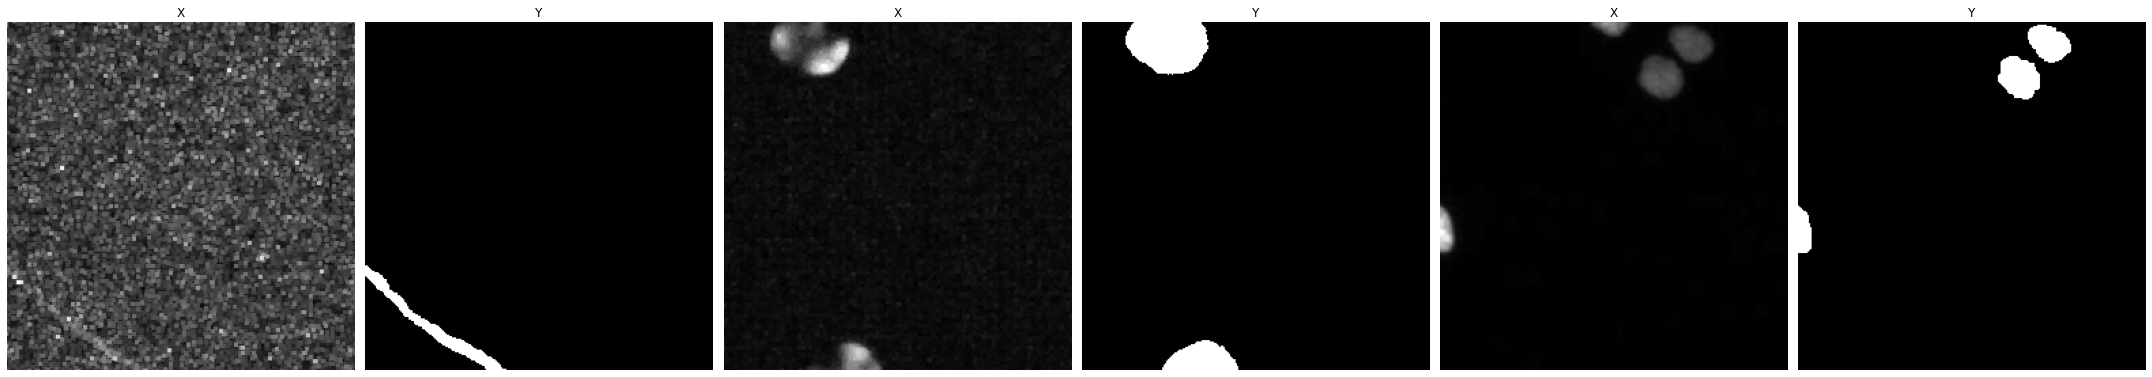

In [25]:
from random import randint
array, labels = [], []

for i in range(3):
    index = randint(0, len(training_x)-1)
    print("Index used:", index)

    array.append( training_x[index] ) 
    array.append( training_y[index] )
    labels.append( "X" )
    labels.append( "Y" )

display(array, labels, figsize=(30, 30))

Index used: 2119
Index used: 250
Index used: 1105


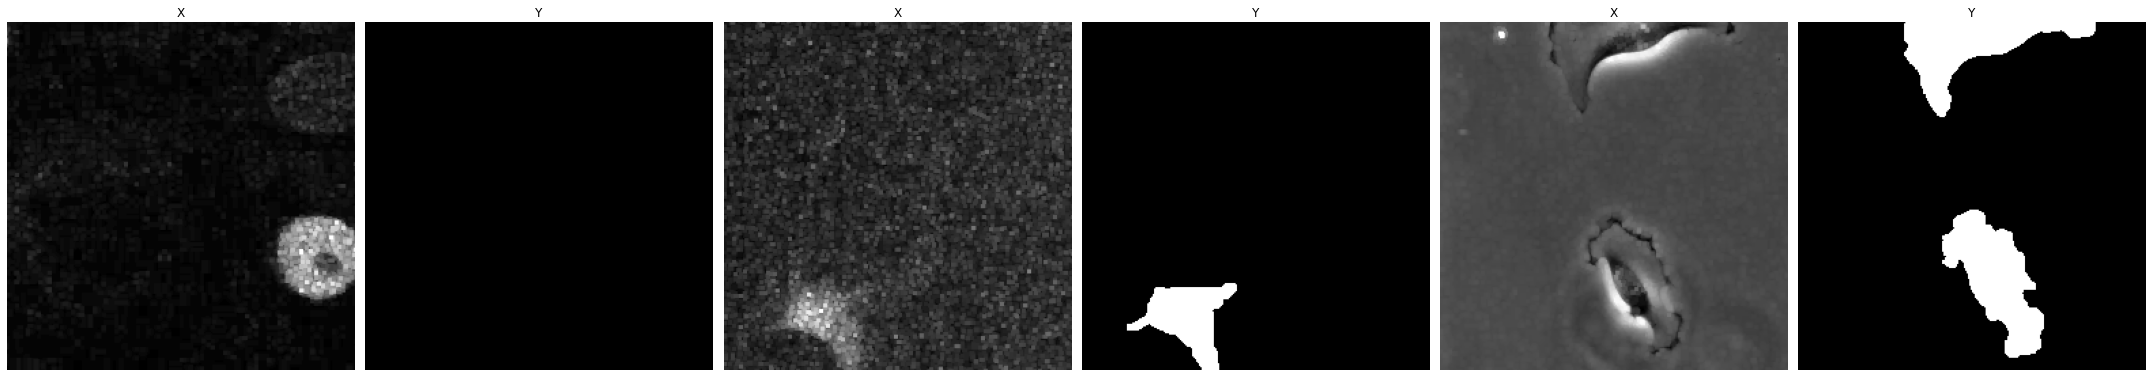

In [26]:
from random import randint
array, labels = [], []

for i in range(3):
    index = randint(0, len(training_x)-1)
    print("Index used:", index)

    array.append( training_x[index] ) 
    array.append( training_y[index] )
    labels.append( "X" )
    labels.append( "Y" )

display(array, labels, figsize=(30, 30))

Now, we can define a Sample Image and Sample Mask in case we with the visualize the training results. The author may disable this callback being used for training as it adds to the RAM usage in Google Colab

## Sample Images

1241


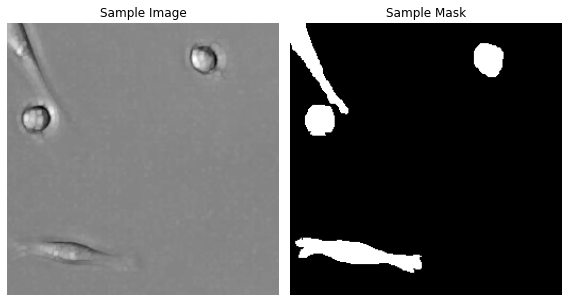

In [27]:
# global variables used for the model training to visualise results
# this will be updated before we train each model

from random import randint

# index = randint(0, len(training_x) - 1)
index = 1241 # useful example, or 528
print(index)

sample_image = training_x[index]
sample_mask = training_y[index]

display( [sample_image, sample_mask], ["Sample Image", "Sample Mask"] , figsize=(8,8))

## Model 1 - 30 epochs, Batch Size of 4

We are attempting to use 2143 images and 1056 masks. This consumes a lot of RAM and is causing Colab to crash. So, instead, let's try use 800 images and 200 masks?

We will also start with 30 epochs just to see if it improves upon the Raw Dataset benchmarks

In [ ]:
patch_size = 256
input_dimensions, output_dimensions = 3, 3
model_name = "UNET_Model_Processed_Images_256_1"

unet_256_model_1 = simple_unet_model(patch_size, 
                                   patch_size, 
                                   input_dimensions, 
                                   output_dimensions, 
                                   model_name
                                   )

unet_256_model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

TRAIN_LENGTH = len(training_x)
BATCH_SIZE = 4
VAL_SUBSPLITS = 5

EPOCHS = 30
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = STEPS_PER_EPOCH // VAL_SUBSPLITS

unet_256_model_1_history = unet_256_model_1.fit(
                                                training_x[0:800],
                                                training_y[0:800], 
                                                epochs=EPOCHS,
                                                callbacks=[DisplayCb()],
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_steps=VALIDATION_STEPS,
                                                validation_data=(test_x[0:200], test_y[0:200])
                                                )

In [ ]:
showTrainingMetrics(unet_256_model_1_history, "Graph showing the Loss and Accuracy for GT 256 patch images")

In [28]:
pred_y = unet_256_model_1.predict(test_x[0:200])

7/7 [==============================] - 11s 200ms/step


97


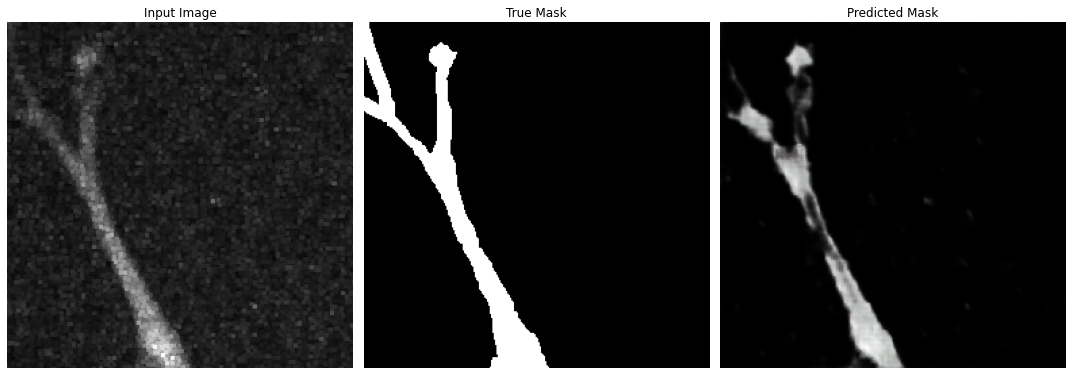

In [29]:
# index = randint(0, len(test_x[200])-1)
index = 97
print(index)

display( display_list=[test_x[index], test_y[index], pred_y[index]] )

170


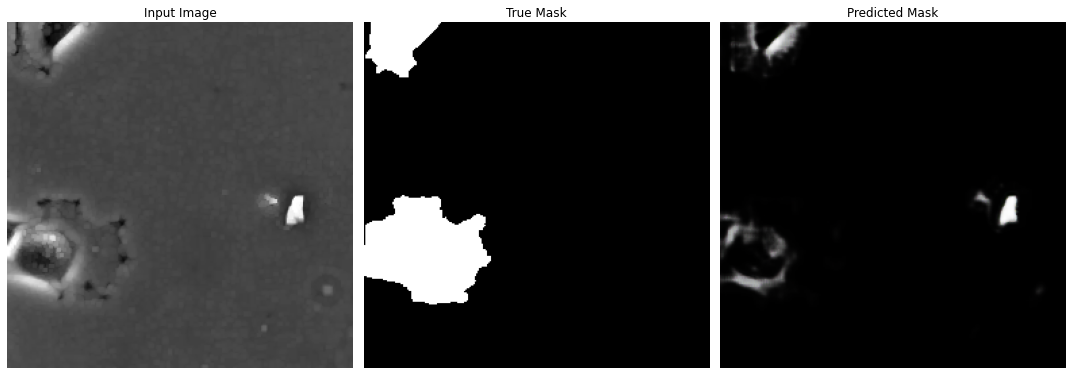

In [30]:
index = 170
print(index)

display( display_list=[test_x[index], test_y[index], pred_y[index]] )

Score:

In [31]:
print("Max Value:", np.max(pred_y))
print("Min Value:", np.min(pred_y))
print("Average value:", np.average(pred_y))

Max Value: 1.0
Min Value: 1.6073697e-09
Average value: 0.032850828


In [32]:
# Next, we can compute the Mean IoU score to see how the model did:
threshold = 0.5

pred_y_thresh = pred_y >= threshold

unet_256_model_score = calculateMeanIouScore(unet_256_model_1, test_x[0:200], test_y[0:200], pred_y_thresh)
print(unet_256_model_score)

0.3064749984064553


### Save Model 1

In [ ]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
tryMakeDirectories(training_data_code, ["COMP700_UNet_Models", "Processed_GT_256"])

path = training_data_code + "COMP700_UNet_Models/Processed_GT_256/"
unet_256_model_1.save(path + "processed_gt_images_256_model_1")

In [ ]:
from keras.models import load_model

new_model = load_model(path + "processed_gt_images_256_model_1")

# Check its architecture
new_model.summary()


## Model 2 - 100 epochs, Batch Size of 4

We are attempting to use 2143 images and 1056 masks. This consumes a lot of RAM and is causing Colab to crash. So, instead, let's try use 800 images and 200 masks?

We will also start with 30 epochs just to see if it improves upon the Raw Dataset benchmarks

In [ ]:
patch_size = 256
input_dimensions, output_dimensions = 3, 3
model_name = "UNET_Model_Processed_Images_256_2"

unet_256_model_2 = simple_unet_model(patch_size, 
                                   patch_size, 
                                   input_dimensions, 
                                   output_dimensions, 
                                   model_name
                                   )

unet_256_model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

TRAIN_LENGTH = len(training_x)
BATCH_SIZE = 4
VAL_SUBSPLITS = 5

EPOCHS = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = STEPS_PER_EPOCH // VAL_SUBSPLITS

unet_256_model_2_history = unet_256_model_2.fit(
                                                training_x[0:800],
                                                training_y[0:800], 
                                                epochs=EPOCHS,
                                                callbacks=[DisplayCb()],
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_steps=VALIDATION_STEPS,
                                                validation_data=(test_x[0:200], test_y[0:200])
                                                )

In [ ]:
showTrainingMetrics(unet_256_model_2_history, "Graph showing the Loss and Accuracy for GT 256 patch images")

In [34]:
pred_y = unet_256_model_2.predict(test_x[0:200])

7/7 [==============================] - 1s 99ms/step


97


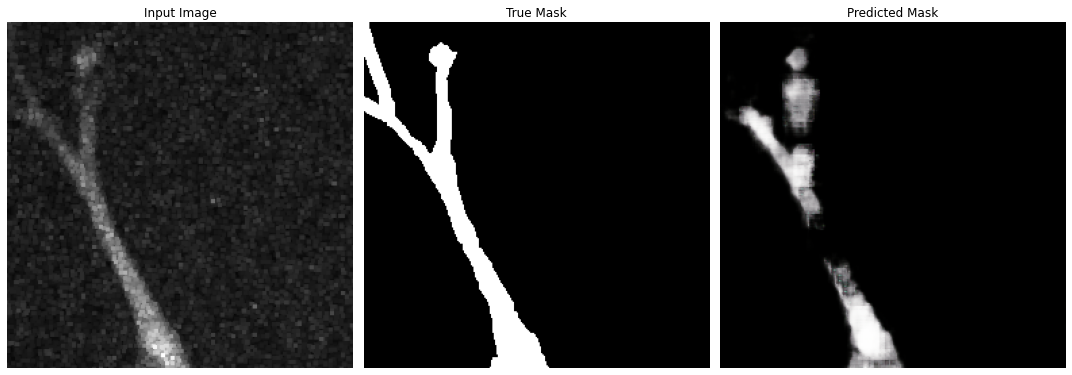

In [35]:
# index = randint(0, len(test_x)-1)
index = 97
print(index)

display( display_list=[test_x[index], test_y[index], pred_y[index]] )

170


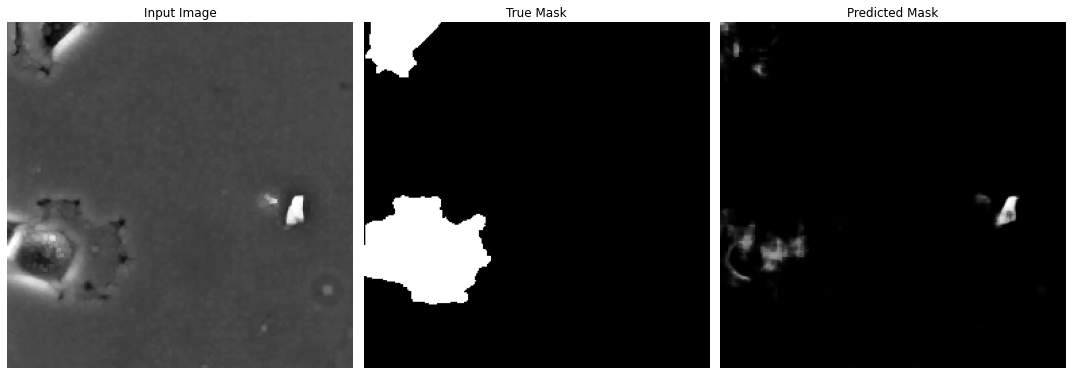

In [36]:
index = 170
print(index)

display( display_list=[test_x[index], test_y[index], pred_y[index]] )

Score:

In [37]:
print("Max Value:", np.max(pred_y))
print("Min Value:", np.min(pred_y))
print("Average value:", np.average(pred_y))

Max Value: 1.0
Min Value: 0.0
Average value: 0.02961004


In [39]:
# Next, we can compute the Mean IoU score to see how the model did:
threshold = 0.5

pred_y_thresh = pred_y >= threshold

unet_256_model_score = calculateMeanIouScore(unet_256_model_2, test_x[0:200], test_y[0:200], pred_y_thresh)
print(unet_256_model_score)

0.2853407364434964


### Save Model 2

In [ ]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
tryMakeDirectories(training_data_code, ["COMP700_UNet_Models", "Processed_GT_256"])

path = training_data_code + "COMP700_UNet_Models/Processed_GT_256/"
unet_256_model_2.save(path + "processed_gt_images_256_model_2")

In [ ]:
from keras.models import load_model

new_model = load_model(path + "processed_gt_images_256_model_2")

# Check its architecture
new_model.summary()


## Model 3 - 100 epochs, Batch Size of 8

We are attempting to use 2143 images and 1056 masks. This consumes a lot of RAM and is causing Colab to crash. So, instead, let's try use 800 images and 200 masks?

We will also start with 30 epochs just to see if it improves upon the Raw Dataset benchmarks

In [ ]:
patch_size = 256
input_dimensions, output_dimensions = 3, 3
model_name = "UNET_Model_Processed_Images_256_3"

unet_256_model_3 = simple_unet_model(patch_size, 
                                   patch_size, 
                                   input_dimensions, 
                                   output_dimensions, 
                                   model_name
                                   )

unet_256_model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

TRAIN_LENGTH = len(training_x)
BATCH_SIZE = 8
VAL_SUBSPLITS = 5

EPOCHS = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = STEPS_PER_EPOCH // VAL_SUBSPLITS

unet_256_model_3_history = unet_256_model_3.fit(
                                                training_x[0:800],
                                                training_y[0:800], 
                                                epochs=EPOCHS,
                                                callbacks=[DisplayCb()],
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_steps=VALIDATION_STEPS,
                                                validation_data=(test_x[0:200], test_y[0:200])
                                                )

In [ ]:
showTrainingMetrics(unet_256_model_3_history, "Graph showing the Loss and Accuracy for GT 256 patch images")

In [43]:
pred_y = unet_256_model_3.predict(test_x[0:200])

7/7 [==============================] - 1s 97ms/step


97


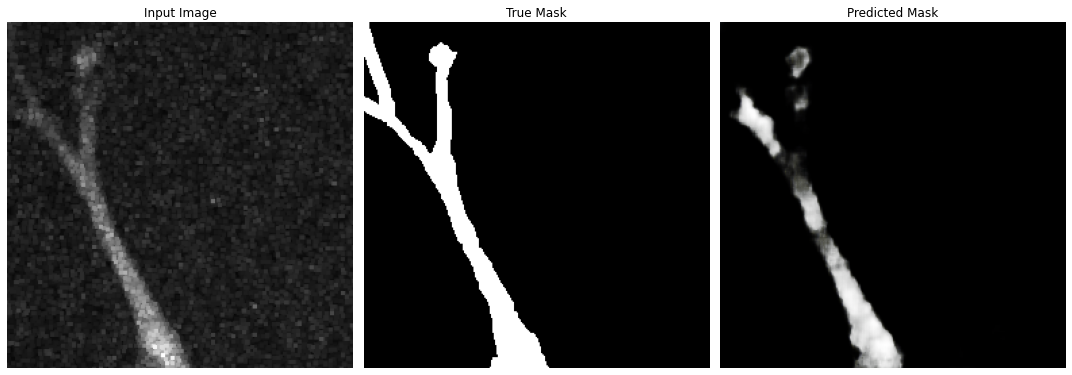

In [44]:
# index = randint(0, len(test_x)-1)
index = 97
print(index)

display( display_list=[test_x[index], test_y[index], pred_y[index]] )

170


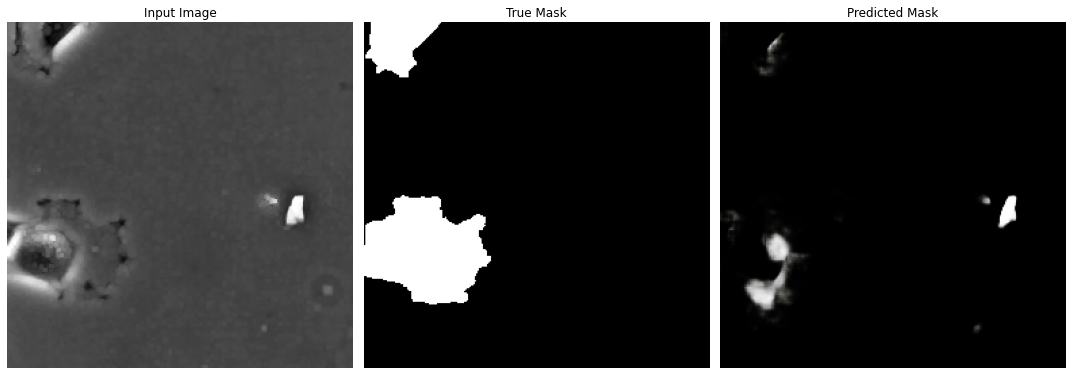

In [45]:
index = 170
print(index)

display( display_list=[test_x[index], test_y[index], pred_y[index]] )

Score:

In [46]:
print("Max Value:", np.max(pred_y))
print("Min Value:", np.min(pred_y))
print("Average value:", np.average(pred_y))

Max Value: 1.0
Min Value: 2.1827225e-26
Average value: 0.03457331


In [47]:
# Next, we can compute the Mean IoU score to see how the model did:
threshold = 0.5

pred_y_thresh = pred_y >= threshold

unet_256_model_score = calculateMeanIouScore(unet_256_model_3, test_x[0:200], test_y[0:200], pred_y_thresh)
print(unet_256_model_score)

0.3434694023324123


### Save Model 3

In [ ]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
tryMakeDirectories(training_data_code, ["COMP700_UNet_Models", "Processed_GT_256"])

path = training_data_code + "COMP700_UNet_Models/Processed_GT_256/"
unet_256_model_3.save(path + "processed_gt_images_256_model_3")

In [ ]:
from keras.models import load_model

new_model = load_model(path + "processed_gt_images_256_model_3")

# Check its architecture
new_model.summary()


# Unet ST 256 Model

## Load images

Can take 20 minutes to load on a new runtime...

In [ ]:
temp_path = getImagePaths(training_data_directory + "COMP700_Patchify_Images_Processed_Images_ST")
collection = []
labels = ["", "", "", ""]

for i in range(len(temp_path)):
    temp = temp_path[i][0]

    collection = temp_path[i]
    collection.sort()

    if ("Training/X" in temp):
      training_x = readImagesViaMatplotlib(collection)
      labels[0] = collection
    elif ("Training/Y" in temp):
      training_y = readImagesViaMatplotlib(collection)
      labels[1] = collection
    elif ("Test/X" in temp):
      test_x = readImagesViaMatplotlib(collection)
      labels[2] = collection
    elif ("Test/Y" in temp):
      test_y = readImagesViaMatplotlib(collection)
      labels[3] = collection
    else:
      print("Unknown path specified")

Processed 0 images out of 2190
Processed 100 images out of 2190
Processed 200 images out of 2190
Processed 300 images out of 2190
Processed 400 images out of 2190
Processed 500 images out of 2190
Processed 600 images out of 2190
Processed 700 images out of 2190
Processed 800 images out of 2190
Processed 900 images out of 2190
Processed 1000 images out of 2190
Processed 1100 images out of 2190
Processed 1200 images out of 2190
Processed 1300 images out of 2190
Processed 1400 images out of 2190
Processed 1500 images out of 2190
Processed 1600 images out of 2190
Processed 1700 images out of 2190
Processed 1800 images out of 2190
Processed 1900 images out of 2190
Processed 2000 images out of 2190
Processed 2100 images out of 2190
Complete
Processed 0 images out of 2190
Processed 100 images out of 2190
Processed 200 images out of 2190
Processed 300 images out of 2190
Processed 400 images out of 2190
Processed 500 images out of 2190
Processed 600 images out of 2190
Processed 700 images out o

In [ ]:
print(len(training_x), ":::", len(training_y))
print(len(test_x), ":::", len(test_y))

2190 ::: 2190
1080 ::: 1080


Verify images match:

In [ ]:
for i in range(5):
    print( extractRhsString(labels[0][i], "/"), ":::", extractRhsString(labels[1][i], "/") )

training_image_0001.png ::: training_mask_0001.png
training_image_0002.png ::: training_mask_0002.png
training_image_0003.png ::: training_mask_0003.png
training_image_0004.png ::: training_mask_0004.png
training_image_0005.png ::: training_mask_0005.png


In [ ]:
count = 0

for i in range(len(training_x)):
    if ( extractRhsString(labels[0][i], "_") != extractRhsString(labels[1][i], "_") ):
        count += 1

print(count, "image(s) do not match")

0 image(s) do not match


## Verify data corresponds

Let us load some images to see the training data we have available to us

Index used: 128
Index used: 366
Index used: 2164


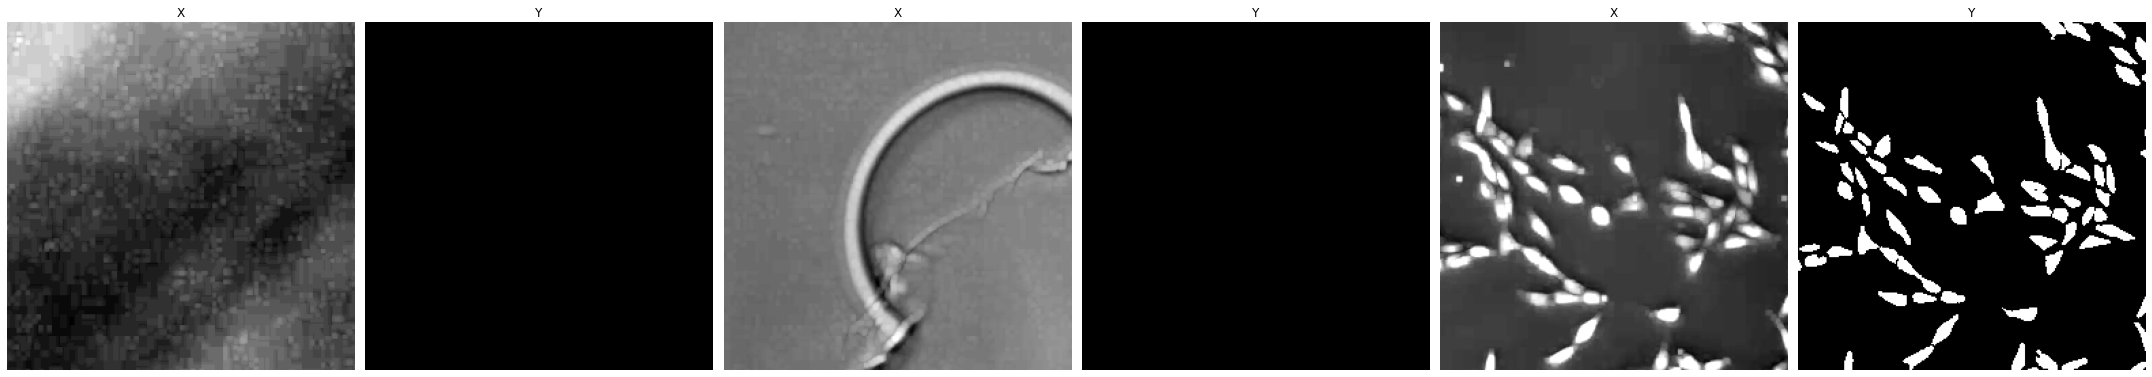

In [ ]:
from random import randint
array, labels = [], []

for i in range(3):
    index = randint(0, len(training_x)-1)
    print("Index used:", index)

    array.append( training_x[index] ) 
    array.append( training_y[index] )
    labels.append( "X" )
    labels.append( "Y" )

display(array, labels, figsize=(30, 30))

Index used: 486
Index used: 1473
Index used: 531


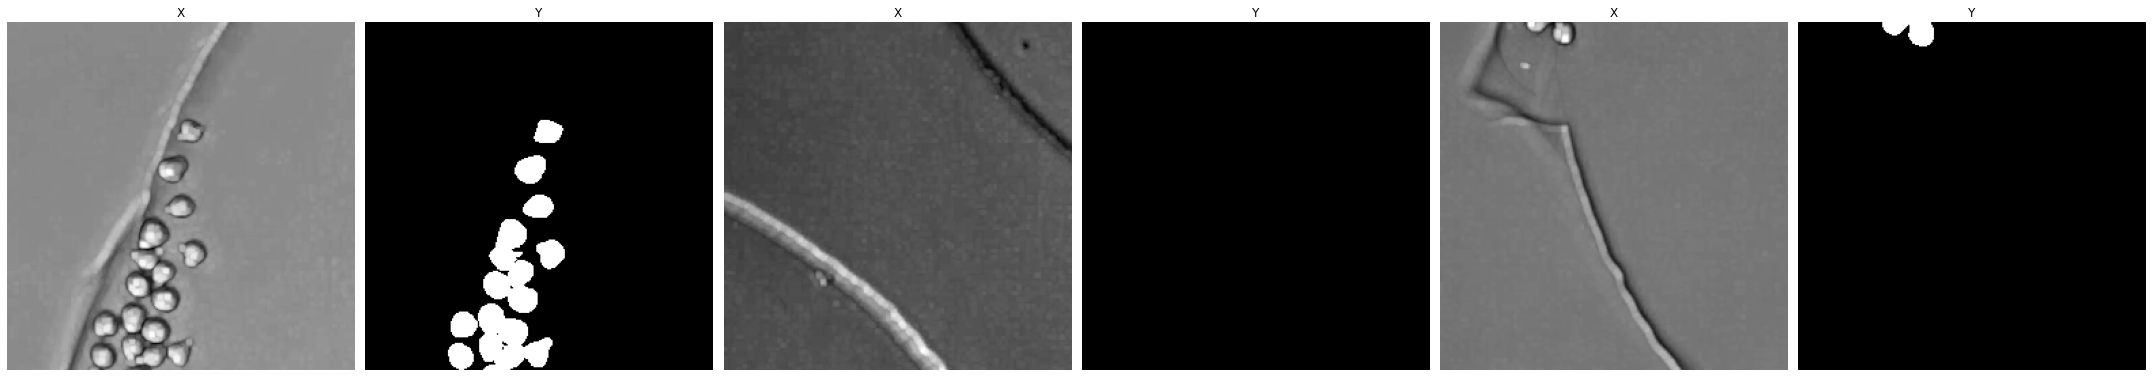

In [ ]:
from random import randint
array, labels = [], []

for i in range(3):
    index = randint(0, len(training_x)-1)
    print("Index used:", index)

    array.append( training_x[index] ) 
    array.append( training_y[index] )
    labels.append( "X" )
    labels.append( "Y" )

display(array, labels, figsize=(30, 30))

Now, we can define a Sample Image and Sample Mask in case we with the visualize the training results. The author may disable this callback being used for training as it adds to the RAM usage in Google Colab

## Sample Images

486


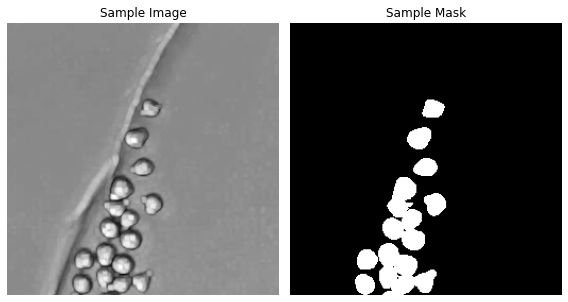

In [ ]:
# global variables used for the model training to visualise results
# this will be updated before we train each model

from random import randint

# index = randint(0, len(training_x) - 1)
index = 486 # useful example, or 2164
print(index)

sample_image = training_x[index]
sample_mask = training_y[index]

display( [sample_image, sample_mask], ["Sample Image", "Sample Mask"] , figsize=(8,8))

## Model 1 - 30 epochs, Batch Size of 4

We are attempting to use 2143 images and 1056 masks. This consumes a lot of RAM and is causing Colab to crash. So, instead, let's try use 800 images and 200 masks?

We will also start with 30 epochs just to see if it improves upon the Raw Dataset benchmarks

1/1 [==============================] - 0s 17ms/step


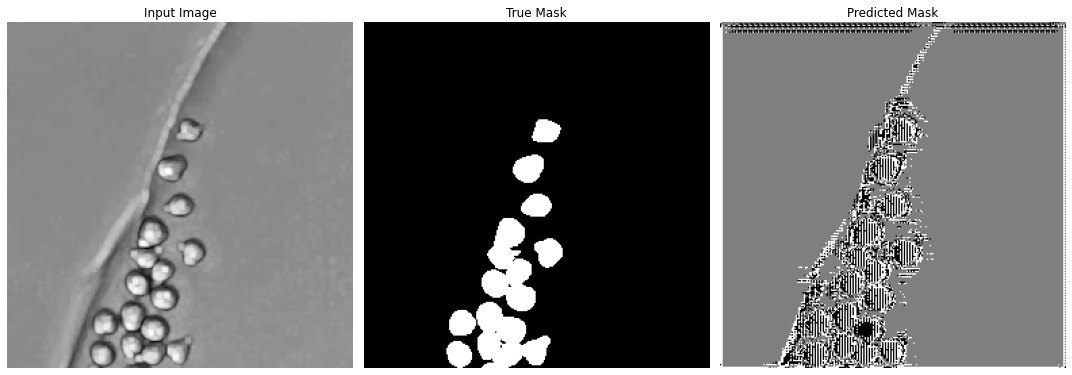


Sample Prediction after epoch 22

547/547 [==============================] - 12s 23ms/step - loss: 0.0359 - accuracy: 0.3785


In [ ]:
patch_size = 256
input_dimensions, output_dimensions = 3, 3
model_name = "UNET_Model_Processed_Images_256_1"

unet_256_model_1 = simple_unet_model(patch_size, 
                                   patch_size, 
                                   input_dimensions, 
                                   output_dimensions, 
                                   model_name
                                   )

unet_256_model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

TRAIN_LENGTH = len(training_x)
BATCH_SIZE = 4
VAL_SUBSPLITS = 5

EPOCHS = 30
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = STEPS_PER_EPOCH // VAL_SUBSPLITS

unet_256_model_1_history = unet_256_model_1.fit(
                                                training_x[0:800],
                                                training_y[0:800], 
                                                epochs=EPOCHS,
                                                callbacks=[DisplayCb()],
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_steps=VALIDATION_STEPS,
                                                validation_data=(test_x[0:200], test_y[0:200])
                                                )

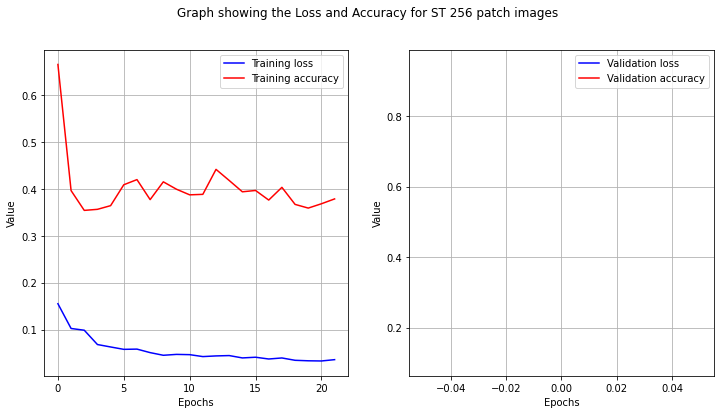

In [ ]:
showTrainingMetrics(unet_256_model_1_history, "Graph showing the Loss and Accuracy for ST 256 patch images")

In [ ]:
pred_y = unet_256_model_1.predict(test_x[0:200])

7/7 [==============================] - 3s 193ms/step


169


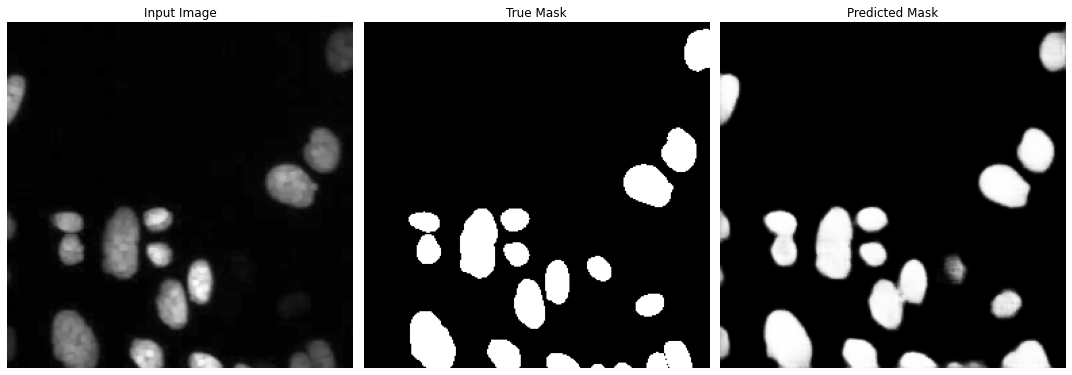

In [ ]:
# index = randint(0, len(test_x[0:200])-1)
index = 169 # 84
print(index)

display( display_list=[test_x[index], test_y[index], pred_y[index]] )

84


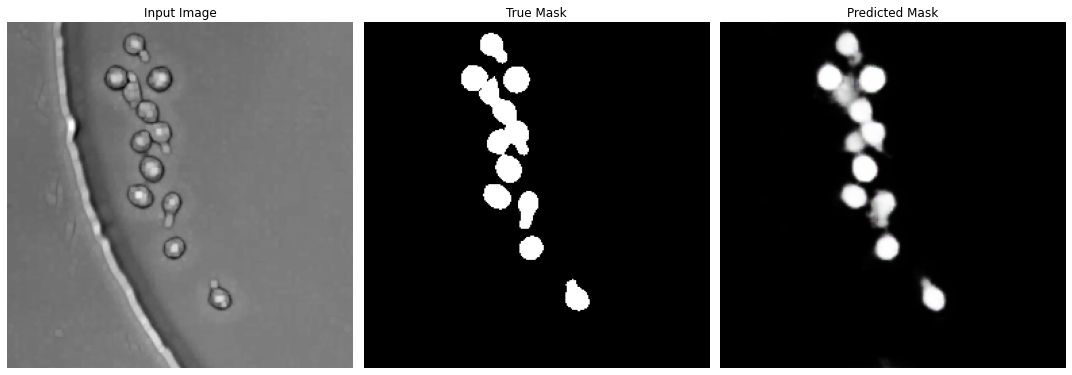

In [ ]:
index = 84
print(index)

display( display_list=[test_x[index], test_y[index], pred_y[index]] )

Score:

In [ ]:
print("Max Value:", np.max(pred_y))
print("Min Value:", np.min(pred_y))
print("Average value:", np.average(pred_y))

Max Value: 1.0
Min Value: 3.3984152e-10
Average value: 0.017737137


In [ ]:
# Next, we can compute the Mean IoU score to see how the model did:
threshold = 0.5

pred_y_thresh = pred_y >= threshold

unet_256_model_score = calculateMeanIouScore(unet_256_model_1, test_x[0:200], test_y[0:200], pred_y_thresh)
print(unet_256_model_score)

0.6410619121647416


### Save Model 1

In [ ]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
tryMakeDirectories(training_data_code, ["COMP700_UNet_Models", "Processed_ST_256"])

path = training_data_code + "COMP700_UNet_Models/Processed_ST_256/"
unet_256_model_1.save(path + "processed_st_images_256_model_1")

In [ ]:
from keras.models import load_model

new_model = load_model(path + "processed_st_images_256_model_1")

# Check its architecture
new_model.summary()


Model: "UNET_Model_Processed_Images_256_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 c1_a (Conv2D)                  (None, 256, 256, 16  448         ['Input[0][0]']                  
                                )                                                                 
                                                                                                  
 c1_b (Dropout)                 (None, 256, 256, 16  0           ['c1_a[0][0]']                   
                                )                                 

## Model 2 - 100 epochs, Batch Size of 4

We are attempting to use 2143 images and 1056 masks. This consumes a lot of RAM and is causing Colab to crash. So, instead, let's try use 800 images and 200 masks?

We will also start with 30 epochs just to see if it improves upon the Raw Dataset benchmarks

1/1 [==============================] - 0s 20ms/step


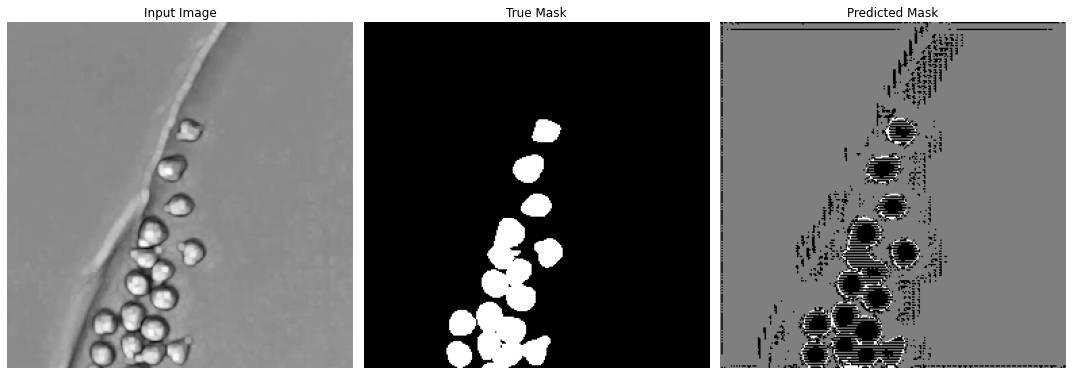


Sample Prediction after epoch 74

547/547 [==============================] - 2s 4ms/step - loss: 0.0123 - accuracy: 0.1724


In [ ]:
patch_size = 256
input_dimensions, output_dimensions = 3, 3
model_name = "UNET_Model_Processed_Images_256_2"

unet_256_model_2 = simple_unet_model(patch_size, 
                                   patch_size, 
                                   input_dimensions, 
                                   output_dimensions, 
                                   model_name
                                   )

unet_256_model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

TRAIN_LENGTH = len(training_x)
BATCH_SIZE = 4
VAL_SUBSPLITS = 5

EPOCHS = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = STEPS_PER_EPOCH // VAL_SUBSPLITS

unet_256_model_2_history = unet_256_model_2.fit(
                                                training_x[0:800],
                                                training_y[0:800], 
                                                epochs=EPOCHS,
                                                callbacks=[DisplayCb()],
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_steps=VALIDATION_STEPS,
                                                validation_data=(test_x[0:200], test_y[0:200])
                                                )

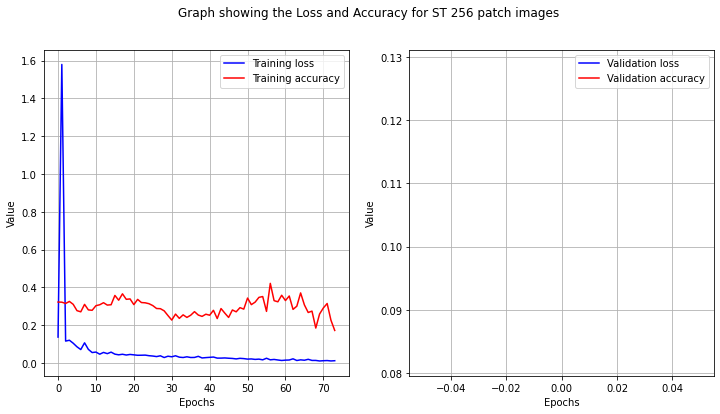

In [ ]:
showTrainingMetrics(unet_256_model_2_history, "Graph showing the Loss and Accuracy for ST 256 patch images")

In [ ]:
pred_y = unet_256_model_2.predict(test_x[0:200])

7/7 [==============================] - 3s 191ms/step


169


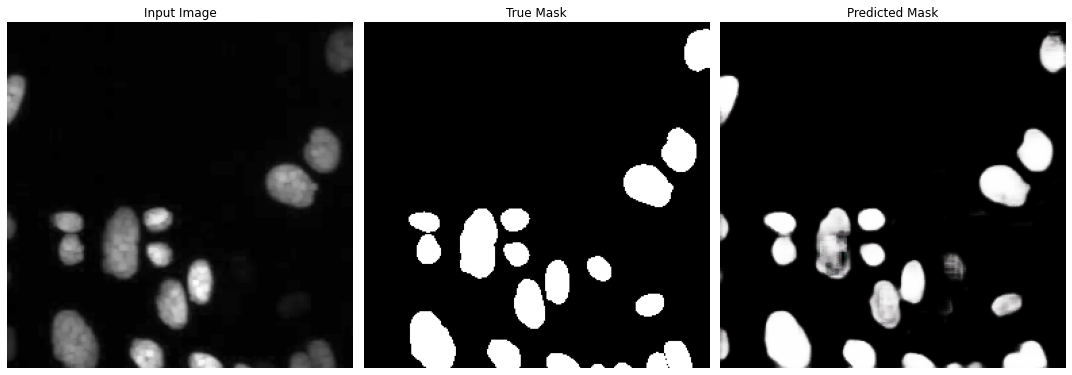

In [ ]:
# index = randint(0, len(test_x[0:200])-1)
index = 169 # 84
print(index)

display( display_list=[test_x[index], test_y[index], pred_y[index]] )

84


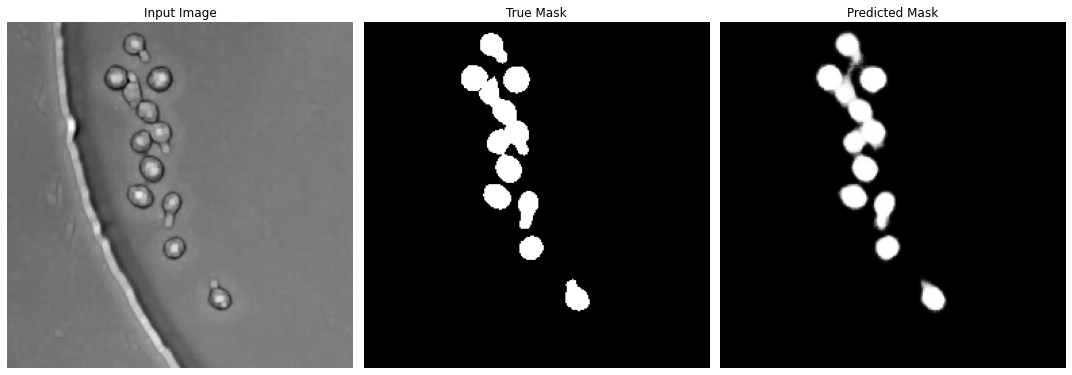

In [ ]:
index = 84
print(index)

display( display_list=[test_x[index], test_y[index], pred_y[index]] )

Score:

In [ ]:
print("Max Value:", np.max(pred_y))
print("Min Value:", np.min(pred_y))
print("Average value:", np.average(pred_y))

Max Value: 1.0
Min Value: 0.0
Average value: 0.016215092


In [ ]:
# Next, we can compute the Mean IoU score to see how the model did:
threshold = 0.5

pred_y_thresh = pred_y >= threshold

unet_256_model_score = calculateMeanIouScore(unet_256_model_2, test_x[0:200], test_y[0:200], pred_y_thresh)
print(unet_256_model_score)

0.7066294110692964


### Save Model 2

In [ ]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
tryMakeDirectories(training_data_code, ["COMP700_UNet_Models", "Processed_ST_256"])

path = training_data_code + "COMP700_UNet_Models/Processed_ST_256/"
unet_256_model_2.save(path + "processed_st_images_256_model_2")

In [ ]:
from keras.models import load_model

new_model = load_model(path + "processed_st_images_256_model_2")

# Check its architecture
new_model.summary()


Model: "UNET_Model_Processed_Images_256_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 c1_a (Conv2D)                  (None, 256, 256, 16  448         ['Input[0][0]']                  
                                )                                                                 
                                                                                                  
 c1_b (Dropout)                 (None, 256, 256, 16  0           ['c1_a[0][0]']                   
                                )                                 

## Model 3 - 100 epochs, Batch Size of 8

We are attempting to use 2143 images and 1056 masks. This consumes a lot of RAM and is causing Colab to crash. So, instead, let's try use 800 images and 200 masks?

We will also start with 30 epochs just to see if it improves upon the Raw Dataset benchmarks

1/1 [==============================] - 0s 22ms/step


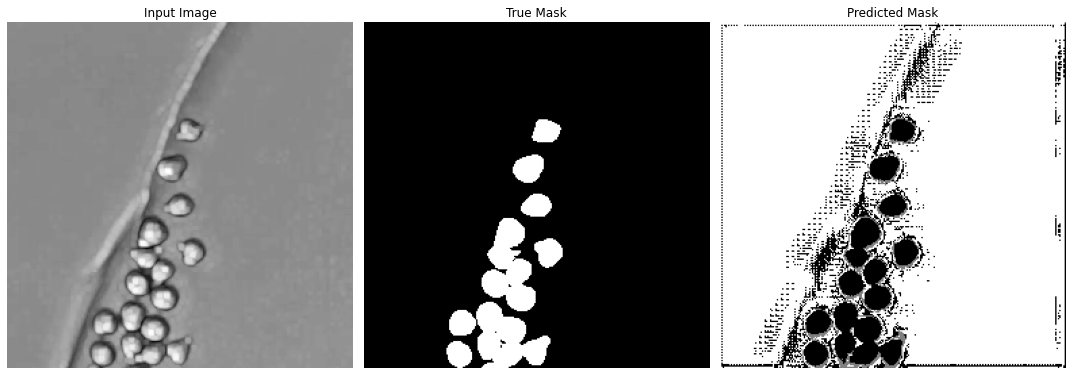


Sample Prediction after epoch 98

273/273 [==============================] - 8s 29ms/step - loss: 0.0084 - accuracy: 0.3932


In [ ]:
patch_size = 256
input_dimensions, output_dimensions = 3, 3
model_name = "UNET_Model_Processed_Images_256_3"

unet_256_model_3 = simple_unet_model(patch_size, 
                                   patch_size, 
                                   input_dimensions, 
                                   output_dimensions, 
                                   model_name
                                   )

unet_256_model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

TRAIN_LENGTH = len(training_x)
BATCH_SIZE = 8
VAL_SUBSPLITS = 5

EPOCHS = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = STEPS_PER_EPOCH // VAL_SUBSPLITS

unet_256_model_3_history = unet_256_model_3.fit(
                                                training_x[0:800],
                                                training_y[0:800], 
                                                epochs=EPOCHS,
                                                callbacks=[DisplayCb()],
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_steps=VALIDATION_STEPS,
                                                validation_data=(test_x[0:200], test_y[0:200])
                                                )

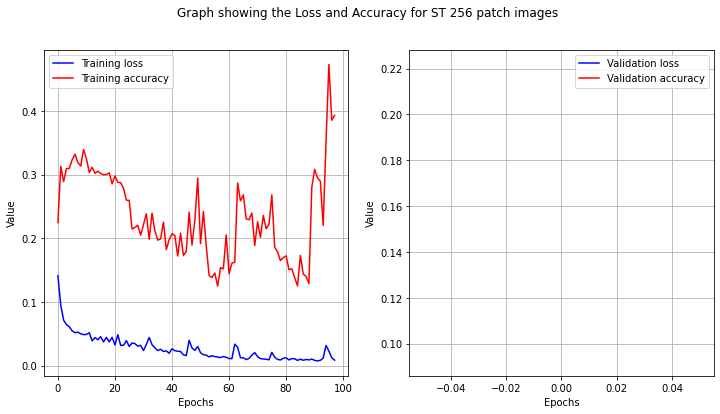

In [ ]:
showTrainingMetrics(unet_256_model_3_history, "Graph showing the Loss and Accuracy for ST 256 patch images")

In [ ]:
pred_y = unet_256_model_3.predict(test_x[0:200])

7/7 [==============================] - 3s 193ms/step


169


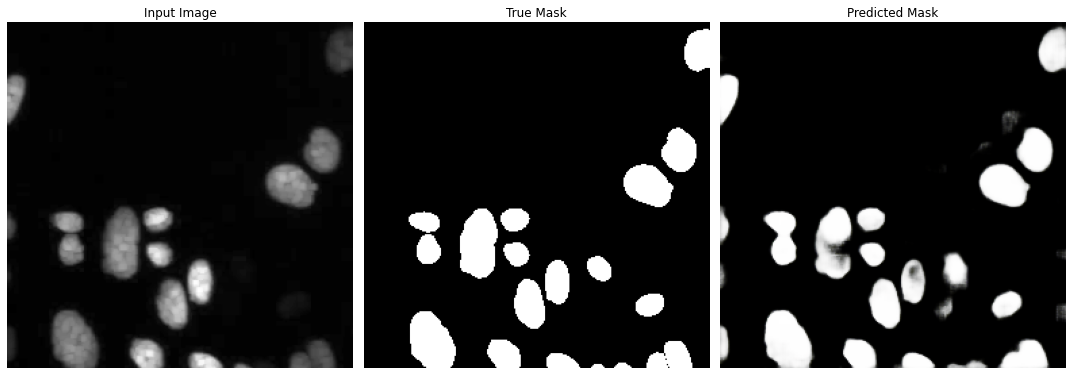

In [ ]:
# index = randint(0, len(test_x[0:200])-1)
index = 169 # 84
print(index)

display( display_list=[test_x[index], test_y[index], pred_y[index]] )

84


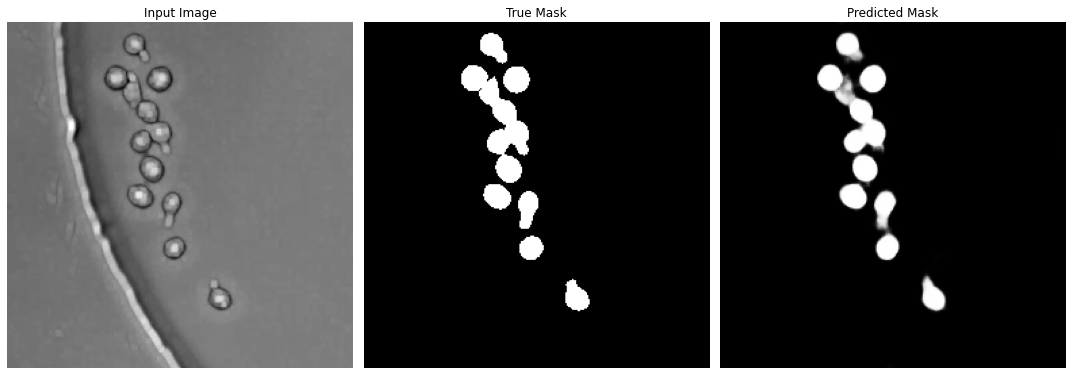

In [ ]:
index = 84
print(index)

display( display_list=[test_x[index], test_y[index], pred_y[index]] )

Score:

In [ ]:
print("Max Value:", np.max(pred_y))
print("Min Value:", np.min(pred_y))
print("Average value:", np.average(pred_y))

Max Value: 1.0
Min Value: 4.0121418e-28
Average value: 0.016704345


In [ ]:
# Next, we can compute the Mean IoU score to see how the model did:
threshold = 0.5

pred_y_thresh = pred_y >= threshold

unet_256_model_score = calculateMeanIouScore(unet_256_model_3, test_x[0:200], test_y[0:200], pred_y_thresh)
print(unet_256_model_score)

0.7099286658116433


### Save Model 3

In [ ]:
training_data_code = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"
tryMakeDirectories(training_data_code, ["COMP700_UNet_Models", "Processed_ST_256"])

path = training_data_code + "COMP700_UNet_Models/Processed_ST_256/"
unet_256_model_3.save(path + "processed_st_images_256_model_3")

In [ ]:
from keras.models import load_model

new_model = load_model(path + "processed_st_images_256_model_3")

# Check its architecture
new_model.summary()


Model: "UNET_Model_Processed_Images_256_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 c1_a (Conv2D)                  (None, 256, 256, 16  448         ['Input[0][0]']                  
                                )                                                                 
                                                                                                  
 c1_b (Dropout)                 (None, 256, 256, 16  0           ['c1_a[0][0]']                   
                                )                                 

# Conclusion


Due to usage restrictions - I am no longer able to use a GPU on the free tier of Google Drive. So, I will instead use the 3 models I just trained to investigate the success of the images and compare information